<a href="https://colab.research.google.com/github/terki-anis/Exercice-de-crunching-data/blob/main/Test_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercice de crunching de data

**Importer les bibliothèques nécessaires**

In [195]:
%matplotlib inline
import os               #os is the library for setting the path
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

Chemin pour accéder aux données

In [155]:
os.chdir('/content/drive/MyDrive/Data/data')

Importer les données

In [156]:
tickets=pd.read_csv('ticket_data.csv')
cities=pd.read_csv('cities.csv')
stations=pd.read_csv('stations.csv')
providers=pd.read_csv('providers.csv')

Pour mieux comprendre les tableaux et afin d'éviter d'afficher de grands tableaux à chaque fois, on va afficher seulement les colonnes

In [157]:
print('le tableau tickets contient les variables :', tickets.columns)
print('le tableau cities contient les variables :',cities.columns)
print('le tableau stations contient les variables :',stations.columns)
print('le tableau providers contient les variables :',providers.columns)

le tableau tickets contient les variables : Index(['id', 'company', 'o_station', 'd_station', 'departure_ts', 'arrival_ts',
       'price_in_cents', 'search_ts', 'middle_stations', 'other_companies',
       'o_city', 'd_city'],
      dtype='object')
le tableau cities contient les variables : Index(['id', 'local_name', 'unique_name', 'latitude', 'longitude',
       'population'],
      dtype='object')
le tableau stations contient les variables : Index(['id', 'unique_name', 'latitude', 'longitude'], dtype='object')
le tableau providers contient les variables : Index(['id', 'company_id', 'provider_id', 'name', 'fullname', 'has_wifi',
       'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type'],
      dtype='object')


Premère observation on peut voir que le tableau ticket contient le plus d'information, et que les 4 tableaux sont tous relié a ce dernier

**affichage des prix**

In [158]:
print('le prix minimale dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].min()/100))
print('le prix maximale dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].max()/100))
print('le prix moyen dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].mean()/100))

le prix minimale dun ticket est 3.00 dollars
le prix maximale dun ticket est 385.50 dollars
le prix moyen dun ticket est 43.83 dollars


**Calcul du temps de trajet**

Avant de calculer la durée de trajet nous allons d'abord transformer nos données en datetime à la place de string

In [159]:
tickets_o=tickets.copy()  #on garde une copie du tableau originale de tickets
tickets['departure_ts']=pd.to_datetime(tickets['departure_ts'])
tickets['arrival_ts']=pd.to_datetime(tickets['arrival_ts'])
#tickets.info() #les variables departure_ts et arrival_ts sont maintenant en date time

On peut voir que les deux colones sont maintenant en datetime
On va donc calculer la durée du trajet

In [160]:
tickets['durée_trjaet']=tickets.arrival_ts -tickets.departure_ts
print('la durée de trajet minimale est',tickets['durée_trjaet'].min())
print('la durée de trajet maximale est',tickets['durée_trjaet'].max())
print('la durée de trajet moyenne est',tickets['durée_trjaet'].mean())

la durée de trajet minimale est 0 days 00:20:00
la durée de trajet maximale est 20 days 12:51:00
la durée de trajet moyenne est 0 days 07:04:37.247600043


**Calcul de la moyenne de prix et de distance selon le type de transport**

D'abord nous allons voir combien de types de transports nous avons dans notre base de données

In [161]:
providers['transport_type'].value_counts()

bus           214
train          10
carpooling      2
car             1
Name: transport_type, dtype: int64

Maintenant qu'on sait que nous avons 4 types de trasports (par bus, par train, par carpooling et en voiture), on va relier les deux tableaux (tickets et providers) avec les deux colonnes reliant les deux et qui sont "id" et "company"

In [162]:
merged_data=pd.merge(tickets, providers, left_on=tickets['company'], right_on=providers['id'], how='left')

In [163]:
print('le prix moyen dun trajet par carpooling est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="carpooling"]
                                                                     ['price_in_cents'].mean()/100))
print('le prix moyen dun trajet par bus est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="bus"]
                                                              ['price_in_cents'].mean()/100))
print('le prix moyen dun trajet par train est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="train"]
                                                                ['price_in_cents'].mean()/100))

le prix moyen dun trajet par carpooling est 27.42 $
le prix moyen dun trajet par bus est 36.52 $
le prix moyen dun trajet par train est 85.07 $


Les prix en fonction de la distance

La première étape est le calcul de la distance entre deux stations (de départ et d'arrivé)
Pour cela nous allons crééer une fonction qui calcul la distance entre les coordonnées de longitulde et laltitulde

Afin de déterminer la distance entre la station de départ et la station d'arrivé nous devons concaténer les deux tableaux (tickets et stations) en fonction des noms de stations.

Avant de concatener les tableaux on va jetter un coup d'oeil sur les valeurs manquantes (elles peuvent causer un problème)

Il y a 55.87 % de valeurs mananquantes dans la colonne "o_station"


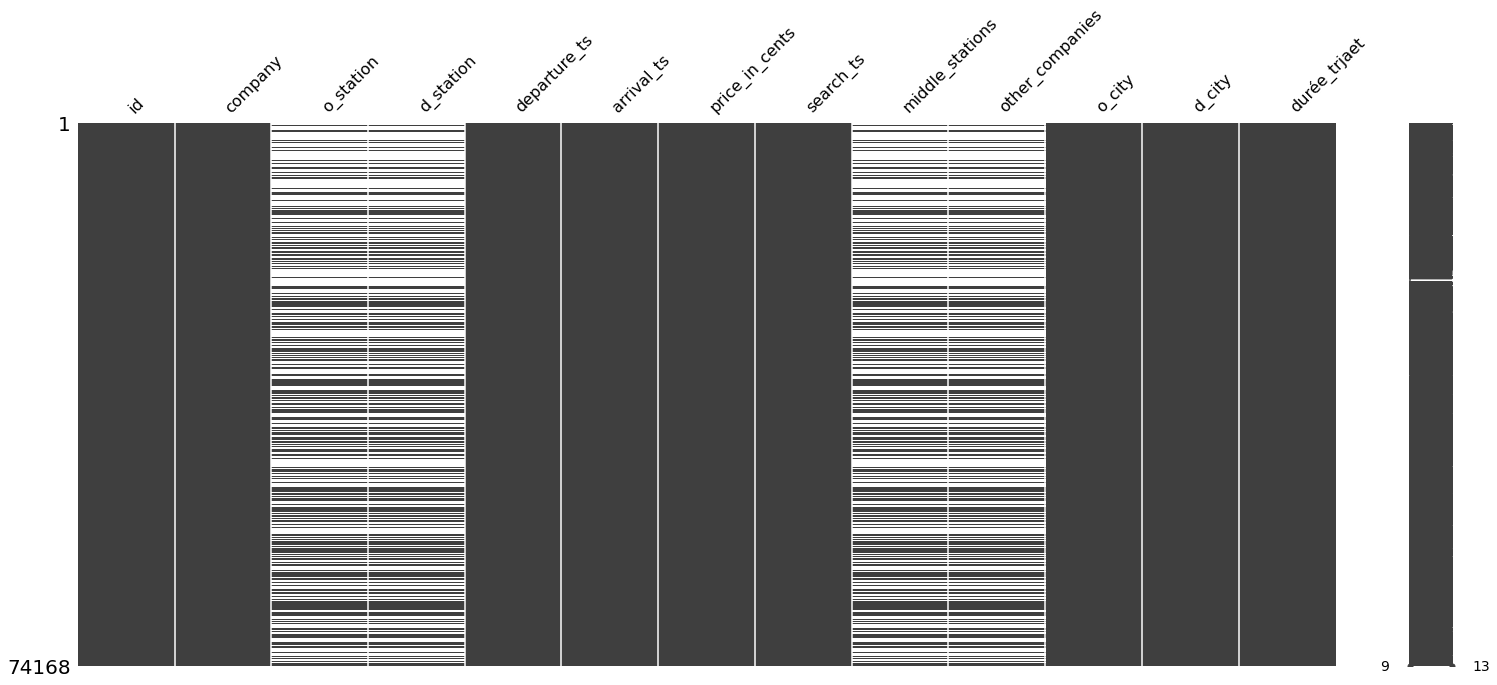

In [164]:
# Visualize missing values as a matrix
msno.matrix(tickets)
print('Il y a {:,.2f} % de valeurs mananquantes dans la colonne "o_station"'
.format(tickets['o_station'].isnull().sum()*100/len(tickets)))

Il y a plusieurs méthodes de traiter les valeurs manquantes, pour le moment on va se contenter d'enlever les lignes qui ne contiennent pas d'information sur les stations de départ et d'arrivé

In [165]:
ticket=tickets.copy() #on recopie le modèle pour garder l'originale
ticket=ticket.dropna()

Maintenant on va joindre les deux tableaux

In [166]:
dist=pd.merge(ticket, stations[['latitude','longitude','unique_name']], left_on=['o_station'], 
              right_on=stations['id'], how='left') #on joint les coordonnées des stations de départ
merged_dist=pd.merge(dist, stations[['latitude','longitude','unique_name']], left_on=['d_station'], right_on=stations['id'],
                     how='left',suffixes=('_départ', '_arrivée')) #jointure des coordonnées des stationsd'arrivé

Une fois le tableau obtenus, passons maintenant au calcul de la distance à partir des coordonnées

In [167]:
#fonction pour le calcul de la distance
def distance(lat1, lat2, lon1, lon2):
  #Convertir des coordonnées en radians
  lon1 = np.deg2rad(lon1)
  lon2 = np.deg2rad(lon2)
  lat1 = np.deg2rad(lat1)
  lat2 = np.deg2rad(lat2)
      
  # Calcul de la distance à l'aide de la méthode de haversine
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  d = 2 * np.arcsin(np.sqrt(a))
  
  #r définie le diamètre de la terre et qui est esttimé a 3956 Kilomètres 
  r = 6371
      
  # la distance finale est donc
  return(d * r)

In [168]:
lo1=merged_dist['longitude_départ']
lo2=merged_dist['longitude_arrivée']
la1=merged_dist['latitude_départ']
la2=merged_dist['latitude_arrivée']
merged_dist['distance']=distance(la1,la2,lo1,lo2)

In [169]:
print('le prix moyen de tickets pour les stations avec les distances entre 0 et 200 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(1, 200, inclusive=True)]['price_in_cents'].mean()/100))
print('le prix moyen de tickets pour les stations avec les distances entre 201 et 800 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(201, 800, inclusive=True)]['price_in_cents'].mean()/100,'dollars'))
print('le prix moyen de tickets pour les stations avec les distances entre 800 et 2000 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(800, 2000, inclusive=True)]['price_in_cents'].mean()/100,'dollars'))
print('le prix moyen de tickets pour les stations avec les distances supérieur a 2000 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance']>2001]['price_in_cents'].mean()/100,'dollars'))

le prix moyen de tickets pour les stations avec les distances entre 0 et 200 km est 30.63 $
le prix moyen de tickets pour les stations avec les distances entre 201 et 800 km est 68.63 $
le prix moyen de tickets pour les stations avec les distances entre 800 et 2000 km est 89.02 $
le prix moyen de tickets pour les stations avec les distances supérieur a 2000 km est nan $


On peut voir que nous n'avons pas d'information sur les trajets à une distance supérieur à 2000km

Une méthode qui pourrait être considéré pour les valeurs manquantes des stations est de remplacer la coordonnées de la station par celle de la ville pour le départ et l'arrivé, ceci dit les résultats obtenus seront très imprécis et on aura beaucoup de valeur qui se répetnent (pour les mêmes villes de départ et d'arrivé) et beaucoup de zéros pour les trajets dans la même ville.

**Allons un peu plus loins**

On va étudier nos données en affichant la localisation de chaque station

In [170]:
#!pip install geopandas

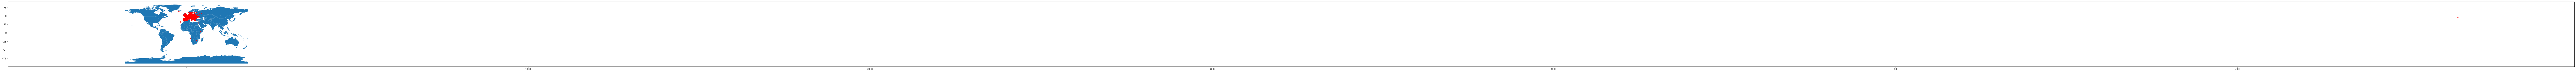

In [178]:
geometry = [Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]
gdf = GeoDataFrame(stations, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(200, 100)), marker='o', color='red', markersize=10)
#taper sur le plot pour une visualisation claire

A premère vu plusières observations peuvent être faites, par exemple les données sont tous de villes de l'europe, ensuite il y a clairement une valeur abhérente sur les coordonnées des stations qui est dans l'extrème droite.
Nous allons localiser cette valeur et l'elever de notre dataset

In [176]:
maxi=stations['longitude'].max() #la valeur maximale est clairement une valeur abhèrente
stations1=stations[stations['longitude']<maxi]

In [181]:
#Affichons la carte encore une fois

geometry = [Point(xy) for xy in zip(stations1['longitude'], stations1['latitude'])]
gdf = GeoDataFrame(stations1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(200, 100)), marker='o', color='red', markersize=10)

Maintenant que la map est prête on peut visualiser plusieurs choses comme par exemple le plus trajet ou le trajet le plus chère...